<a href="https://colab.research.google.com/github/Kamran0153/Channel-State-Information-Prediction/blob/main/CSIPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Channel State Information Generation and Prediction
We consider a single downlink communication system, where a Base Station (BS) transmits information to a mobile user. The mobile user obtains samples of the channel conditions in the downlink and reports the noisy channel state information to the BS. However, due to communication errors or delay, the received channel information in the BS is not fresh. BS uses the stale and noise channel state information to predict the current channel state information. We consider a Rayleigh feading channel model. In this notebook, we will generate Rayleigh fading channel. Then, using the noisy sequence of stale channels, we will predict current channel state information.

# Import Necessary Packages

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Dataset Generation
The Rayleigh fading process with unit variance is generated by using sum of sinusoids method described in https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1512123


Let $h[j]=h_{re}[j]+i h_{im}[j]$ be the channel state information at time $j$

In [30]:
fc=2*10e9 #carrier frequency
c=3*10e8
v=15 # user velocity
fd=fc*v/c #doppler frequency
Ts=0.001 #sampling time
a=0
b=2*np.pi
M=124 #Number of sinusoids
alpha=a+(b-a)*np.random.uniform(0,1,M) #uniformly distributed from 0 to 2 pi
beta=a+(b-a)*np.random.uniform(0,1,M) #uniformly distributed from 0 to 2 pi
theta=a+(b-a)*np.random.uniform(0,1,M) #uniformly distributed from 0 to 2 pi
m=np.arange(M)+1;
x=np.cos(((2*m-1)*np.pi+theta)/(4*M))

In [31]:
N=100000 #Number of time sequence
h_re=np.zeros(N)
h_im=np.zeros(N)
for n in range(N):

  h_re[n]=1/np.sqrt(M)*np.sum(np.cos(2*np.pi*fd*x*n*Ts+alpha))
  h_im[n]=1/np.sqrt(M)*np.sum(np.sin(2*np.pi*fd*x*n*Ts+beta))


# Create Feature and Target Variables
Target variables at time $j$ is $y[j]=h[j]$ and the feature is the sequence of channel state information. Let $X[j]=(h[j], h[j-1], \ldots, h[j-u+1])$ be the sequence of channel information, where $u$ is called feature length

In [32]:
#Feature
X=np.vstack((h_re, h_im))
X=np.transpose(X)
#Target
y=X

#Adding Noise to the channel sequence
for i in range(len(X)):
 X[i]=X[i]+np.random.normal(0, 10e-6,2)

#We are removing last 100 samples
l=len(y)
y=y[0:l-100]
Xt=X[0:l-100,:]

u=10 #feature length
print('size of the feature', u)

# Creating feature with $u$ sequence of channel information
a=np.zeros(u)
for j in range(u):
    Xt=np.hstack((Xt,X[j+1:l-99+j,:]))
X=Xt

size of the feature 10


# Generate the Inference Error Function


Our goal is to predict $y[j]$ based on $X[j-\delta]$, where $\delta$ is the age of infroamtion. We will use quadratic loss function. Because $y[j]$ and $X[j-\delta]$ are jointy Gaussian, linear regression is the optimal choice among the supervised learning algorithms.

In [33]:
i=20 #number of Age values in the simulation
l=len(y)
age=np.zeros(i)
score1=np.zeros(i) # Training Error
score2=np.zeros(i) # Inference Error

for n in range(i):
  age[n]=n
  y_t=y[0:l-n]
  X_t=X[n:l, :]


  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.20)
  from sklearn.linear_model import LinearRegression
  regressor = LinearRegression()
  regressor.fit(X_train, y_train)

  y_predtrain = regressor.predict(X_train)
  y_predtest =  regressor.predict(X_test)
  from sklearn.metrics import mean_squared_error
  score1[n]=mean_squared_error(y_train, y_predtrain)
  score2[n]=mean_squared_error(y_test, y_predtest)

print('InferenceError=', score2)


InferenceError= [6.39132100e-31 1.10230635e-07 3.70188165e-06 4.57450180e-05
 3.12608567e-04 1.49883434e-03 5.40976371e-03 1.54338289e-02
 3.61818954e-02 7.06852676e-02 1.18984883e-01 1.76308192e-01
 2.25181271e-01 2.59773234e-01 2.73828432e-01 2.77046910e-01
 2.79375942e-01 2.86289592e-01 3.02830170e-01 3.18430870e-01]


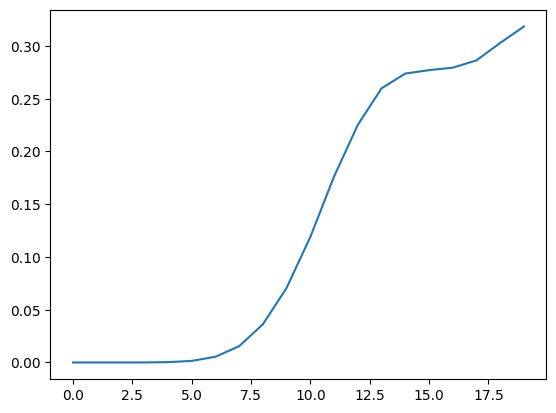

In [34]:
plt.plot(score2)